In [1]:
!export HDF5_DISABLE_VERSION_CHECK=1

In [14]:
# builtins
import sys
import os
import time
import logging
from datetime import timedelta
from logging.config import dictConfig
import numpy as np
import datetime
import pathlib
import pandas as pd
import joblib

# externals
import xarray as xr

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

# locals
from downscaleml.core.dataset import ERA5Dataset, NetCDFDataset, EoDataset

from downscaleml.main.config import (ERA5_PATH, OBS_PATH, DEM_PATH, MODEL_PATH, TARGET_PATH, 
                                     NET, ERA5_PLEVELS, ERA5_PREDICTORS, PREDICTAND,
                                     CALIB_PERIOD, VALID_PERIOD, DOY, NORM,
                                     OVERWRITE, DEM, DEM_FEATURES, STRATIFY,
                                     WET_DAY_THRESHOLD, VALID_SIZE, 
                                     start_year, end_year, CHUNKS, PROJECTION_PATH)

#from downscaleml.main.inputoutput import ()

from downscaleml.core.constants import (ERA5_P_VARIABLES, ERA5_P_VARIABLES_SHORTCUT, ERA5_P_VARIABLE_NAME,
                                        ERA5_S_VARIABLES, ERA5_S_VARIABLES_SHORTCUT, ERA5_S_VARIABLE_NAME,
                                        ERA5_VARIABLES, ERA5_VARIABLE_NAMES, ERA5_PRESSURE_LEVELS,
                                        PREDICTANDS, ERA5_P_VARIABLES, ERA5_S_VARIABLES)

from downscaleml.core.utils import NAMING_Model, normalize, search_files, LogConfig
from downscaleml.core.logging import log_conf
    
# module level logger
LOGGER = logging.getLogger(__name__)

def stacker(xarray_dataset):
    # stack along the lat and lon dimensions
    stacked = xarray_dataset.stack()
    dask_arr = stacked.to_array().data
    xarray_dataset = dask_arr.T
    LogConfig.init_log('Shape is in (spatial, time, variables):{}'.format(xarray_dataset.shape))
    return xarray_dataset

def doy_encoding(X, y=None, doy=False):

    # whether to include the day of the year as predictor variable
    if doy:
        # add doy to set of predictor variables
        LOGGER.info('Adding day of the year to predictor variables ...')
        X = X.assign(EoDataset.encode_doys(X, chunks=X.chunks))

    print(X)
    return X

if __name__ == '__main__':

    # initialize timing
    start_time = time.monotonic()
        
    # initialize network filename
    state_file = NAMING_Model.state_file(
        NET, PREDICTAND, ERA5_PREDICTORS, ERA5_PLEVELS, WET_DAY_THRESHOLD, dem=DEM,
        dem_features=DEM_FEATURES, doy=DOY, stratify=STRATIFY)
    
    state_file = MODEL_PATH.joinpath(PREDICTAND, state_file)
    target = TARGET_PATH.joinpath(PREDICTAND)

    # check if output path exists
    if not target.exists():
        target.mkdir(parents=True, exist_ok=True)
    # initialize logging
    log_file = state_file.with_name(state_file.name + "_log.txt")
    
    if log_file.exists():
        log_file.unlink()
    dictConfig(log_conf(log_file))

    LogConfig.init_log('Initializing downscaling for period: {}'.format(
        ' - '.join([str(CALIB_PERIOD[0]), str(CALIB_PERIOD[-1])])))

    # initialize ERA5 predictor dataset
    LogConfig.init_log('Initializing ERA5 predictors.')
    Era5 = ERA5Dataset(ERA5_PATH, ERA5_PREDICTORS,
                       plevels=ERA5_PLEVELS)
    Era5_ds = Era5.merge(chunks=CHUNKS)
    Era5_ds = Era5_ds.rename({'lon': 'x','lat': 'y'})

    LogConfig.init_log('Initializing PROJECTION predictors.')
    #TEMPORARY PATHWORK HERE - SOLVE IT FOR LATER
    Cmip6 = ERA5Dataset(PROJECTION_PATH.joinpath('ssp245/r101i1p1f1/'), ERA5_PREDICTORS,
                       plevels=ERA5_PLEVELS)
    Cmip6_ds = Cmip6.merge(chunks=CHUNKS)
    Cmip6_ds = Cmip6_ds.rename({'lon': 'x','lat': 'y'})

    
    # initialize OBS predictand dataset
    LogConfig.init_log('Initializing observations for predictand: {}'
                       .format(PREDICTAND))

    # read in-situ gridded observations
    Obs_ds = search_files(OBS_PATH.joinpath(PREDICTAND), '.nc$').pop()
    Obs_ds = xr.open_dataset(Obs_ds)
    Obs_ds = Obs_ds.rename({'lon': 'x','lat': 'y'})

    DEM = None

    # whether to use digital elevation model
    if DEM:
        # digital elevation model: Copernicus EU-Dem v1.1
        dem_path = search_files(DEM_PATH, '^mswx_dem.nc$').pop()

        # read elevation and compute slope and aspect
        dem = ERA5Dataset.dem_features(
            dem_path, {'y': Era5_ds.y, 'x': Era5_ds.x},
            add_coord={'time': Era5_ds.time})
        
        dem_cmip6 = ERA5Dataset.dem_features(
            dem_path, {'y': Cmip6_ds.y, 'x': Cmip6_ds.x},
            add_coord={'time': Cmip6_ds.time})

        # check whether to use slope and aspect
        if not DEM_FEATURES:
            dem = dem.drop_vars(['slope', 'aspect']).chunk(Era5_ds.chunks)
            dem_cmip6 = dem_cmip6.drop_vars(['slope', 'aspect']).chunk(Cmip6_ds.chunks)
            

        # add dem to set of predictor variables
        dem = dem.chunk(Era5_ds.chunks)
        Era5_ds = xr.merge([Era5_ds, dem])
        Cmip6_ds = xr.merge([Cmip6_ds, dem_cmip6])

    # initialize training data
    LogConfig.init_log('Initializing training data.')

    # split calibration period into training and validation period
    if PREDICTAND == 'pr' and STRATIFY:
        # stratify training and validation dataset by number of
        # observed wet days for precipitation
        wet_days = (Obs_ds.sel(time=CALIB_PERIOD).mean(dim=('y', 'x'))
                    >= WET_DAY_THRESHOLD).to_array().values.squeeze()
        train, valid = train_test_split(
            CALIB_PERIOD, stratify=wet_days, test_size=VALID_SIZE)

        # sort chronologically
        train, valid = sorted(train), sorted(valid)
        Era5_train, Obs_train = Era5_ds.sel(time=train), Obs_ds.sel(time=train)
        Era5_valid, Obs_valid = Era5_ds.sel(time=valid), Obs_ds.sel(time=valid)
    else:
        LogConfig.init_log('We are not calculating Stratified Precipitation based on Wet Days here!')

    # training and validation dataset
    Era5_train, Obs_train = Era5_ds.sel(time=CALIB_PERIOD), Obs_ds.sel(time=CALIB_PERIOD)
    Cmip6_valid = Cmip6_ds.sel(time=VALID_PERIOD)
    Cmip6_valid_dummy = Cmip6_ds.sel(time=VALID_PERIOD)

    #Era5_valid, Obs_valid = Era5_ds.sel(time=VALID_PERIOD), Obs_ds.sel(time=VALID_PERIOD)

    Era5_train = doy_encoding(Era5_train, Obs_train, doy=DOY)
    Cmip6_valid = doy_encoding(Cmip6_valid, Cmip6_valid_dummy, doy=DOY)

    LogConfig.init_log('{}'.format(Era5_train))
    LogConfig.init_log('{}'.format(Cmip6_valid))


downscaleml.core.utils: --------------------------------------------------------------------------------
downscaleml.core.utils: 2024-08-05T14:01:24: Initializing downscaling for period: 1979-01-01 - 2014-12-31
downscaleml.core.utils: --------------------------------------------------------------------------------
downscaleml.core.utils: --------------------------------------------------------------------------------
downscaleml.core.utils: 2024-08-05T14:01:24: Initializing ERA5 predictors.
downscaleml.core.utils: --------------------------------------------------------------------------------
downscaleml.core.utils: Searching: /mnt/CEPH_PROJECTS/InterTwin/Climate_Downscaling/cmip_downscale/HISTORICAL/r101i1p1f1/geopotential, pattern: .nc$
downscaleml.core.utils: Searching: /mnt/CEPH_PROJECTS/InterTwin/Climate_Downscaling/cmip_downscale/HISTORICAL/r101i1p1f1/temperature, pattern: .nc$
downscaleml.core.utils: Searching: /mnt/CEPH_PROJECTS/InterTwin/Climate_Downscaling/cmip_downscale/HIS

<xarray.Dataset> Size: 6GB
Dimensions:  (time: 13149, x: 107, y: 64)
Coordinates:
  * time     (time) datetime64[ns] 105kB 1979-01-01 1979-01-02 ... 2014-12-31
  * x        (x) float32 428B 5.15 5.25 5.35 5.45 ... 15.45 15.55 15.65 15.75
  * y        (y) float32 256B 49.95 49.85 49.75 49.65 ... 43.85 43.75 43.65
    height   float64 8B ...
Data variables: (12/16)
    zg_250   (time, y, x) float32 360MB dask.array<chunksize=(363, 64, 107), meta=np.ndarray>
    zg_500   (time, y, x) float32 360MB dask.array<chunksize=(363, 64, 107), meta=np.ndarray>
    zg_850   (time, y, x) float32 360MB dask.array<chunksize=(363, 64, 107), meta=np.ndarray>
    ta_250   (time, y, x) float32 360MB dask.array<chunksize=(363, 64, 107), meta=np.ndarray>
    ta_500   (time, y, x) float32 360MB dask.array<chunksize=(363, 64, 107), meta=np.ndarray>
    ta_850   (time, y, x) float32 360MB dask.array<chunksize=(363, 64, 107), meta=np.ndarray>
    ...       ...
    va_500   (time, y, x) float32 360MB dask.array<c

downscaleml.core.utils: --------------------------------------------------------------------------------
downscaleml.core.utils: 2024-08-05T14:01:37: <xarray.Dataset> Size: 6GB
Dimensions:  (time: 13149, x: 107, y: 64)
Coordinates:
  * time     (time) datetime64[ns] 105kB 1979-01-01 1979-01-02 ... 2014-12-31
  * x        (x) float32 428B 5.15 5.25 5.35 5.45 ... 15.45 15.55 15.65 15.75
  * y        (y) float32 256B 49.95 49.85 49.75 49.65 ... 43.85 43.75 43.65
    height   float64 8B ...
Data variables: (12/16)
    zg_250   (time, y, x) float32 360MB dask.array<chunksize=(363, 64, 107), meta=np.ndarray>
    zg_500   (time, y, x) float32 360MB dask.array<chunksize=(363, 64, 107), meta=np.ndarray>
    zg_850   (time, y, x) float32 360MB dask.array<chunksize=(363, 64, 107), meta=np.ndarray>
    ta_250   (time, y, x) float32 360MB dask.array<chunksize=(363, 64, 107), meta=np.ndarray>
    ta_500   (time, y, x) float32 360MB dask.array<chunksize=(363, 64, 107), meta=np.ndarray>
    ta_850   (

<xarray.Dataset> Size: 14GB
Dimensions:  (time: 31410, x: 107, y: 64)
Coordinates:
  * time     (time) datetime64[ns] 251kB 2015-01-01 2015-01-02 ... 2100-12-30
  * x        (x) float32 428B 5.15 5.25 5.35 5.45 ... 15.45 15.55 15.65 15.75
  * y        (y) float32 256B 49.95 49.85 49.75 49.65 ... 43.85 43.75 43.65
Data variables: (12/16)
    zg_250   (time, y, x) float32 860MB dask.array<chunksize=(365, 64, 107), meta=np.ndarray>
    zg_500   (time, y, x) float32 860MB dask.array<chunksize=(365, 64, 107), meta=np.ndarray>
    zg_850   (time, y, x) float32 860MB dask.array<chunksize=(365, 64, 107), meta=np.ndarray>
    ta_250   (time, y, x) float32 860MB dask.array<chunksize=(365, 64, 107), meta=np.ndarray>
    ta_500   (time, y, x) float32 860MB dask.array<chunksize=(365, 64, 107), meta=np.ndarray>
    ta_850   (time, y, x) float32 860MB dask.array<chunksize=(365, 64, 107), meta=np.ndarray>
    ...       ...
    va_500   (time, y, x) float32 860MB dask.array<chunksize=(365, 64, 107), me

/home/sdhinakaran/micromamba/envs/check/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


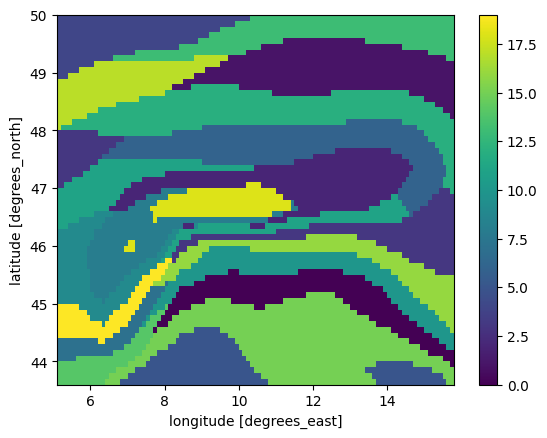

In [15]:
from sklearn.cluster import KMeans

ds = Era5_train.mean(dim='time')
lat_lon_flat = ds.to_array().stack(points=('y', 'x')).T.values

n_clusters = 20  # Example: Set number of clusters to 5
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
kmeans.fit(lat_lon_flat)

cluster_labels = kmeans.labels_

clustered_map = cluster_labels.reshape(ds.sizes['y'], ds.sizes['x'])

clustered_da = xr.DataArray(clustered_map, coords=[ds['y'], ds['x']], dims=['y', 'x'])

# Plot the clustered data array
plt.figure(figsize=(10, 6))
clustered_da.plot()
plt.title("KMeans Clustering of Era5 Data")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Save the plot
plt.savefig('/home/sdhinakaran/my_Notebooks/clustered_map_plot.png')

plt.show()


/home/sdhinakaran/micromamba/envs/check/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


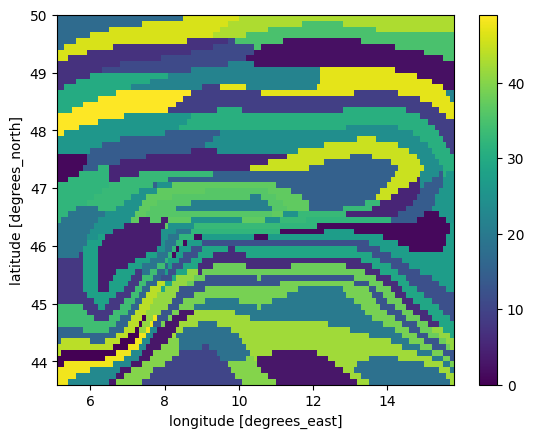

In [16]:
n_clusters = 50  # Example: Set number of clusters to 5
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
kmeans.fit(lat_lon_flat)

cluster_labels = kmeans.labels_

clustered_map = cluster_labels.reshape(ds.sizes['y'], ds.sizes['x'])

clustered_da = xr.DataArray(clustered_map, coords=[ds['y'], ds['x']], dims=['y', 'x'])

clustered_da.plot()


/home/sdhinakaran/micromamba/envs/check/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


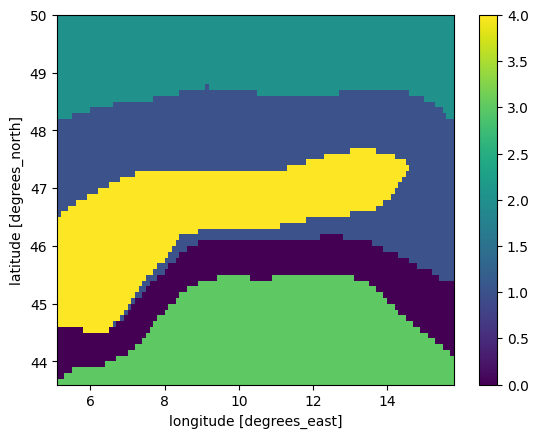

In [18]:
n_clusters = 5  # Example: Set number of clusters to 5
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
kmeans.fit(lat_lon_flat)

cluster_labels = kmeans.labels_

clustered_map = cluster_labels.reshape(ds.sizes['y'], ds.sizes['x'])

clustered_da = xr.DataArray(clustered_map, coords=[ds['y'], ds['x']], dims=['y', 'x'])

clustered_da.plot()
